In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.cyc_gbm import CycGBM
from scipy.optimize import minimize

In [2]:
n = 1000
rng = np.random.default_rng(seed=10)
X0 = np.arange(0, n)
X1 = np.arange(0, n)
rng.shuffle(X1)
mu = np.exp(1 * (X0 > 0.3 * n) + 0.5 * (X1 > 0.5 * n))
v = np.exp(-0.5 + 0.1 * X0 - 0.3 * np.abs(X1))

X = np.stack([X0, X1]).T
alpha = mu * (1 + v)
beta = v + 2
y0 = np.random.beta(alpha, beta)
y = y0 / (1 - y0)

max_depth = 2
min_samples_leaf = 20
eps = 0.1
kappa = [20,100]

In [3]:
gbm = CycGBM(kappa=kappa, eps=eps, max_depth = max_depth, min_samples_leaf=min_samples_leaf, dist = 'beta_prime')
gbm.train(X, y)
z_hat = gbm.predict(X)

loss = gbm.dist.loss(z_hat, y).sum()
print(loss)

-745.4360954913807


In [4]:
gbm.z0

array([ 0.99797502, -0.42538934])

In [5]:
z0_0=np.array([np.log(y.mean()),np.log(y.mean()*(1+y.mean())/y.var())])

In [6]:
gbm.dist.loss(z0_0,y).sum()

-201.06057740852464

In [7]:
gbm.dist.loss(gbm.z0,y).sum()

-178.43246540393176

In [8]:
# Conversion to old structure
zOpt = gbm.z0
BOpts = kappa
BOpt = max(kappa)
d = 2
epsilon = [eps]*d

In [9]:
# Distribution dependent
from scipy.special import polygamma as pg
from scipy.special import loggamma as lg
# Loss function
def lossEval(z,y):
    mu  = np.exp(z[0])
    v = np.exp(z[1])
    loss = (mu+v+mu*v)*np.log(y+1) - mu*(v+1)*np.log(y) + lg(mu*(v+1)) + lg(v+2) - lg(mu+v+mu*v+2)
    return loss

# Gradients
def grad0(z,y):
    # Parameter values
    mu  = np.exp(z[0])
    v = np.exp(z[1])
    # Calulate gradient
    grad = mu*(1+v)*(pg(0,mu*(1+v))-pg(0,mu+v+mu*v+2)+np.log((1+y)/y))
    return grad

def grad1(z,y):
    # Parameter values
    mu  = np.exp(z[0])
    v = np.exp(z[1])
    # Calulate gradient
    grad = v*(mu*np.log((y+1)/y)+np.log(y+1) + mu*pg(0,mu*(v+1)) + pg(0,v+2) - (mu+1)*pg(0,mu*(v+1)+v+2))
    return grad

# Gradient list
grads = [grad0,grad1]

In [10]:
# Setup
from sklearn.tree import DecisionTreeRegressor as regressionTree
# Tree fitting function
def trainTree(z, y, x, grad, max_depth, min_samples_leaf):
    tree = regressionTree(max_depth = max_depth, min_samples_leaf = min_samples_leaf)
    g = grad(z,y)
    tree.fit(x,-g)
    return tree

# Dimension indicator for score adding
e = [np.stack([[0]]*j+[[1]] +[[0]]*(d-j-1)) for j in range(0,d)]

# Local tree training function
def trainThisTree(z, y, x, grad, max_depth = max_depth, min_samples_leaf = min_samples_leaf):
    return trainTree(z,y,x,grad,max_depth,min_samples_leaf)

In [17]:
# Training and validation data
xTrain, yTrain = X, y
xValid, yValid = X, y
nTrain, nValid = len(yTrain), len(yValid)

# Initiate score
zTrain = zOpt.repeat(nTrain).reshape((d,nTrain))
zValid = zOpt.repeat(nValid).reshape((d,nValid))

# Build trees
for b in range(1,BOpt):
    # For all parameter dimensions
    for j in range(0,d):
        if b<BOpts[j]:
            # Fit a tree
            tree = trainThisTree(zTrain,yTrain,xTrain,grads[j])

            # Score updates
            zTrainPlus = tree.predict(xTrain)
            zValidPlus = tree.predict(xValid)

            # Look at all unique node values
            nodeValues = np.unique(zTrainPlus)
            for k,nodeValue in enumerate(nodeValues):
                # Indices with this node value
                indicesTrain = zTrainPlus==nodeValue
                indicesValid = zValidPlus==nodeValue
                # Optimize step size
                gammaOpt = minimize(lambda gamma: lossEval(zTrain[:,indicesTrain] + e[j]*gamma,yTrain[indicesTrain]).sum(),
                                    jac = lambda gamma: (grads[j](zTrain[:,indicesTrain] + e[j]*gamma,yTrain[indicesTrain])).sum(),
                                    x0 = nodeValue)['x'][0]
                # Manipulate node values
                zTrainPlus[indicesTrain] = gammaOpt
                zValidPlus[indicesValid] = gammaOpt

            # Update score
            zTrain[j] += epsilon[j]*zTrainPlus
            zValid[j] += epsilon[j]*zValidPlus



In [18]:
lossEval(zValid, yValid).sum()


-912.216547744553

In [20]:
gbm.dist.loss(z_hat,y).sum()

-745.4360954913807

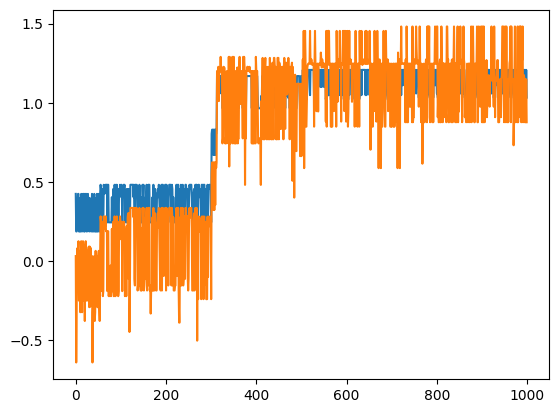

In [22]:
plt.plot(zValid[0])
plt.plot(z_hat[0])

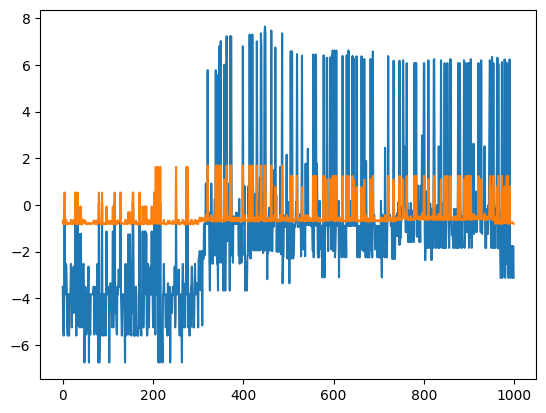

In [21]:
plt.plot(zValid[1])
plt.plot(z_hat[1])
